<a href="https://colab.research.google.com/github/cr00z/dlschool_adv/blob/main/Roman_Netrebin_stepik87915176.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Сегментация изображений

Для дополнительной тренировки в использовании PyTorch код я немного переписал. Глюки есть, но не судите строго :)

In [ ]:
!pip install torchsummary gdown
#!pip install albumentations==0.4.6

  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=f362691300c86f7a1bda38bb769b56af29f7fc6ea1e9f37f721e8d529af624a7
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown


In [ ]:
#import warnings
#warnings.simplefilter('error', UserWarning)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import os
import numpy as np
import pandas as pd
from skimage import io
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as tfs
import torchvision.models
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from IPython.display import clear_output
from tqdm.notebook import tqdm
import pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
content_dir = '/kaggle/working/PH2Dataset'
batch_size = 16

# Загрузка данных

В ходе выполнения расположение файлов поменялось, поэтому появились закомменченые строки. Падал сайт института, сейчас сайт заработал, может старые ссылки и работают - не пробовал.

In [ ]:
if not os.path.exists(content_dir):
    print('Download dataset...')
    # !wget --quiet https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
    !gdown https://drive.google.com/uc?id=12eqGNI4twFQKiiGVoWKQiblVIsdLK1vw -O PH2Dataset.zip
    # print('Install unrar...', end='')
    # !apt-get -qq install unrar > /dev/null 2>&1
    # print('done.')
    print('Extract archive files...', end='')
    #!unrar x -idq PH2Dataset.rar
    !unzip -q PH2Dataset.zip
    print('done.')

Download dataset...
Downloading...
From: https://drive.google.com/uc?id=12eqGNI4twFQKiiGVoWKQiblVIsdLK1vw
To: /kaggle/working/PH2Dataset.zip
100%|█████████████████████████████████████████| 213M/213M [00:00<00:00, 322MB/s]
Extract archive files...done.


С skimage я разобрался, но работа с ней мне не понравилась. Написал свой кастомный класс с применением трансформаций. Добавил немного аугментации с использованием [albumentations](https://albumentations.ai/)

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.transform = transform
        self.samples = []
        self.labels = []
        for root, dirs, files in os.walk(main_dir):
            if root.endswith('_Dermoscopic_Image'):
                self.samples.append(os.path.join(root, files[0]))
            if root.endswith('_lesion'):
                self.labels.append(os.path.join(root, files[0]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # image = Image.open(self.samples[idx])
        # label = Image.open(self.labels[idx])
        image = cv2.imread(self.samples[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = cv2.imread(self.labels[idx], cv2.IMREAD_GRAYSCALE)
        transformed = self.transform(image=image, mask=label)
        tensor_image = transformed['image'].transpose(2, 0, 1)
        label_image = transformed['mask'][np.newaxis, :]
        tensor_image = torch.FloatTensor(tensor_image) / 255
        label_image = torch.FloatTensor(label_image) / 255
        #print(tensor_image.shape, label_image.shape)
        #print(tensor_image.min(), tensor_image.max(), label_image.min(), label_image.max())
        return tensor_image, label_image
    
#     def __getitem__(self, idx):
#         image = Image.open(self.samples[idx])
#         tensor_image = self.transform(image)
#         label = Image.open(self.labels[idx])
#         label_image = self.transform(label)
#         print(tensor_image.min(), tensor_image.max(), label_image.min(), label_image.max())
#         return tensor_image, label_image

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.augmentations.geometric.Affine(
        scale={'x':(1.0, 1.2), 'y':(1.0, 1.2)},
# #        cval=[55, 51, 49],
# #        mode=cv2.BORDER_CONSTANT
    )
    #A.ToFloat(),
    #A.pytorch.ToTensorV2(),
    #A.Normalize(mean=0, std=1),
    #tfs.RandomAffine(10,translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

# transform = tfs.Compose([
#     tfs.Resize((256, 256)),
#     tfs.ToTensor(),
# ])

dermoscopic_dataset = CustomDataSet(os.path.join(content_dir, 'PH2 Dataset images'), transform=transform)

idx = np.random.choice(len(dermoscopic_dataset), len(dermoscopic_dataset), False)
#train_idx, valid_idx, test_idx = np.split(idx, [100, 150])
train_idx, test_idx = np.split(idx, [150])

dataset_train = Subset(dermoscopic_dataset, train_idx)
#dataset_valid = Subset(dermoscopic_dataset, valid_idx)
dataset_test  = Subset(dermoscopic_dataset, test_idx)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
#dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Визуализация

С установленным трешхолдом приводит к маске (0;1), без - рисует как есть: в grayscale вероятностями (0,1)

In [ ]:
def show_dermoscopic_imgs(images, labels, threshold=None):
    images = images.numpy().transpose(0, 2, 3, 1)
    labels = labels.numpy().transpose(0, 2, 3, 1)
    if threshold is not None:
        labels = np.where(labels > threshold, 1, 0)
    plt.figure(figsize=(18, 6))
    for i in range(4):
        plt.subplot(2, 6, i+1)
        plt.imshow(images[i])
        plt.axis("off")

        plt.subplot(2, 6, i+7)
        plt.imshow(labels[i], cmap='gray')
        plt.axis("off")
    # plt.show()

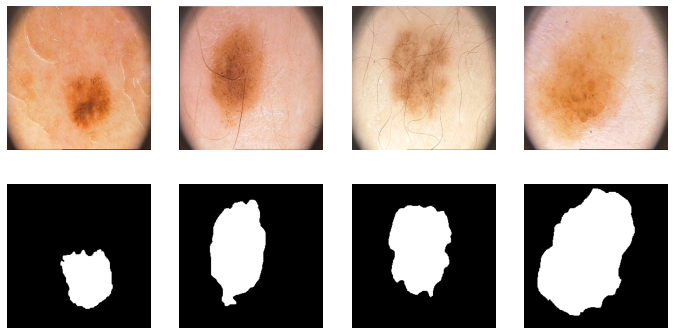

In [ ]:
images, labels = next(iter(dataloader_train))
show_dermoscopic_imgs(images, labels)

In [ ]:
def show_loss(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history)
    plt.title('Loss')
    plt.show()

# Metrics

Good summary: [A survey of loss functions for semantic segmentation](https://arxiv.org/pdf/2006.14822.pdf)

## IoU scoring metric

$$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$$

Из метрики выбросил трешолд, по описанию автора это привязка к конкурсу TGS Salt Identification Challenge, нужно ли это нам? 

In [ ]:
SMOOTH = 1e-6
# https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.byte()
    labels = labels.byte()
    #print(outputs)
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    #outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    # return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    return iou

## BCE Loss

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right]$$

In [ ]:
class BCELoss_classic(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        if reduction not in ('mean', 'sum'):
            raise ValueError('"{}" is not a valid mode for reduction. Only "mean"'
                             'and "sum" are allowed.'.format(rediction))
        self.reduction = reduction
        
    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        # outputs = torch.clamp(outputs, 0, 1)
        outputs = torch.sigmoid(outputs)
        bce = labels * torch.log(outputs + SMOOTH) + (1 - labels) * torch.log(1 - outputs + SMOOTH)
        if self.reduction == 'mean':
            return -torch.mean(bce)
        elif self.reduction == 'sum':
            return -torch.sum(bce)

$$\mathcal L_{BCE}(y, \hat y) = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right)$$

In [ ]:
class BCELoss_with_logits(nn.Module):
    def __init__(self, reduction='mean', truncate=False):
        super().__init__()
        if reduction not in ('mean', 'sum'):
            raise ValueError('"{}" is not a valid mode for reduction. Only "mean"'
                             'and "sum" are allowed.'.format(rediction))
        self.reduction = reduction
        self.truncate = truncate
        
    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        # classical without sigmoid
        # but you need to cut off large negative logits, otherwise it will be -inf -> nan 
        if self.truncate:
            outputs = torch.sigmoid(outputs)
        outputs = outputs.float()
        labels = labels.float()
        # print(torch.min(outputs))
        bce = outputs - labels * outputs + torch.log(1 + torch.exp(-outputs))
        if self.reduction == 'mean':
            return torch.mean(bce)
        elif self.reduction == 'sum':
            return torch.sum(bce)

Тоже подвержена численной неустойчивости, т.к у нас на входе в лосс логиты, которые могут быть сильно отрицательны, тогда torch.mean(torch.log(1 + torch.exp(torch.tensor(-(-255))))) становится inf и вся тренировка модели заканчивается. Я обернул логиты в сигмоиду, но скорее всего такой подход не верен - расчеты с библиотечными функциями не совпадет. Но по факту - величина лосса не главное, тренируется и так.

In [ ]:
output = torch.Tensor([
    [-0.4717,  0.8484,  0.7424],
    [ 0.0880,  0.1379,  0.8387],
    [ 0.3874, -1.8205,  1.5422]
])
target = torch.Tensor([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
])
sigm = nn.Sigmoid()

print(
    output,
    target,
    nn.BCELoss(reduction='mean')(sigm(output), target),
    BCELoss_classic(reduction='mean')(output, target),
    BCELoss_with_logits(reduction='mean')(output, target),
    sep='\n'
)

tensor([[-0.4717,  0.8484,  0.7424],
        [ 0.0880,  0.1379,  0.8387],
        [ 0.3874, -1.8205,  1.5422]])
tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]])
tensor(0.9288)
tensor(0.9288)
tensor(0.9288)


## Dice Loss

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Пробовал реализовать по приведенной формуле, но где-то ошибся - не дает нормально тренировать модель. Реализовал по другой формуле, с заранее суммированными предиктами и метками - она более стабильна.

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()

#     # not work, why?
#     def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
#         coef = 1 / (outputs.shape[0] * outputs.shape[2] * outputs.shape[3])
#         outputs = torch.sigmoid(outputs)
#         num = 2 * outputs * labels
#         den = outputs + labels
#         res = 1 - coef * ((num + 1)/(den + 1)).sum()
#         return res

    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        outputs = torch.sigmoid(outputs)
        num = 2 * (outputs * labels).sum()
        den = (outputs + labels).sum()
        res = 1 - (num + SMOOTH) / (den + SMOOTH)
        return res

## Focal Loss

Нашел вот такой вывод лосса, реализовал по нему:

$$FL(p_t) = -\alpha_t(1-p_t)^\gamma log(p_t)$$
$$CE(p,y) = CE(p_t) = -log(p_t)$$
$$p_t = e^{-CE(p_t)}$$
$$FL(p_t) = \alpha_t(1-e^{-CE(p_t)})^\gamma CE(p_t)$$

In [ ]:
# https://arxiv.org/pdf/1708.02002.pdf
class FocalLoss(nn.Module):
    def __init__(self, alpha: int = 1, gamma: int = 2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        bce_logit = nn.BCEWithLogitsLoss()
        ce = bce_logit(outputs, labels)
        pt = torch.exp(-ce)
        fl = self.alpha * torch.pow((1 - pt), self.gamma) * ce
        return fl

## Tversky Loss

[Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

$$TI(p,\hat p) = \frac{p\hat p}{p\hat p + \beta(1 − p)\hat p + (1 − \beta)p(1 − \hat p)}$$
$$TL(p,\hat p) = 1 - \frac{1 + p\hat p}{1+ p\hat p + \beta(1 − p)\hat p + (1 − \beta)p(1 − \hat p)}$$

In [ ]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha:int = 0.5, beta:int = 0.5):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        outputs = torch.sigmoid(outputs)
        pp = (labels * outputs).sum()
        den1 = self.alpha * ((1 - labels) * outputs).sum()
        den2 = self.beta * (labels * (1 - outputs)).sum()
        tl = 1 - (1 + pp) / (1 + pp + den1 + den2)
        return tl       

## Focal Tversky Loss

In [ ]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha:int = 0.5, beta:int = 0.5, gamma:int = 2):
        super().__init__()
        self.gamma = gamma
        self.tl = TverskyLoss(alpha, beta)
        
    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        tl = self.tl(outputs, labels)
        return torch.pow(tl, self.gamma)

## Lovasz Loss

In [ ]:
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/67791
class LovaszLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        #outputs = torch.sigmoid(outputs)
        outputs = outputs.flatten()
        labels = labels.flatten()
        signs = 2 * labels.float() - 1
        errors = (1 - outputs * signs)
        errors_sorted, indices = torch.sort(errors, dim=0, descending=True)
        gt_sorted = labels[indices.data]

        # gradient
        gts = gt_sorted.sum()
        intersection = gts - gt_sorted.float().cumsum(0)
        union = gts + (1 - gt_sorted).float().cumsum(0)
        grad = 1. - intersection / union

        p = len(gt_sorted)
        grad[1:p] = grad[1:p] - grad[0:-1]
       
        loss = torch.dot(torch.relu(errors_sorted), grad)
        return loss

# Train/valid functions

Тут все стандартно еще из Симпсонов, единственное - добавил скор в цикл обучения, чтобы потом построить графики.

In [ ]:
def score_model(model, metric, data, threshold=0):
    model.to(device).eval() # testing mode
    scores = 0
    threshold = torch.tensor(threshold).to(device)
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        with torch.no_grad():
            Y_pred = model(X_batch)
        scores += metric((Y_pred > threshold), Y_label.to(device)).mean().item()
    return scores/len(data)

In [ ]:
def train_model(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.nn.Module,
    dataloader_train: torch.utils.data.DataLoader,
    dataloader_test: torch.utils.data.DataLoader,
    epochs: int = 20
) -> (torch.nn.Module, dict):
    r"""Training the model. Returns list of train losses.
    Args:
        model (torch.nn.Module): Neural network
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        dataloader_train: (torch.utils.data.DataLoader): Train data
        dataloader_valid: (torch.utils.data.DataLoader): Valid data
        epochs (int): Number of training iterations. Default: 20
    """
#def train(model, optimizer, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(dataloader_test))
    losses = []
    metric = []
  
    for epoch in range(epochs):
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(dataloader_train, desc='Progress'):
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            optimizer.zero_grad()
            # forward
            # print(Y_batch.shape)
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            print(loss)
            loss.backward() # backward-pass
            optimizer.step()  # update weights
            # calculate loss to show the user
            avg_loss += loss / len(dataloader_train)

        losses.append(avg_loss.item())
        metric.append(score_model(model, iou_pytorch, dataloader_test))
        
        # show intermediate results
        model.eval()  # testing mode
        # detach and put into cpu
        Y_hat = model(X_val.to(device)).detach().cpu()
        # Visualize tools
        clear_output(wait=True)
        show_dermoscopic_imgs(X_val, Y_hat, threshold=0.1)
        plt.title('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return losses, metric

In [ ]:
def predict(model, data):
    model.to(device).eval()  # testing mode
    with torch.no_grad():
        Y_pred = [model(X_batch.to(device)) for X_batch, _ in data]
    return Y_pred

# SegNet

По описанию авторов они брали кодер от VGG16, я его скопировал оттуда, единственное - добавил батчнормы, так модель обучается лучше.

Сначала реализовал как набор слоев, потом обернул последовательности слоев в функции.

In [ ]:
# vgg16 = torchvision.models.vgg16_bn()
# vgg16.features

In [ ]:
class SegNet(nn.Module):
    def _enc_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _dec_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
  
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0 = nn.Sequential(self._enc_layer(3, 64), self._enc_layer(64, 64))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(self._enc_layer(64, 128), self._enc_layer(128, 128))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(self._enc_layer(128, 256), self._enc_layer(256, 256), self._enc_layer(256, 256))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(self._enc_layer(256, 512), self._enc_layer(512, 512), self._enc_layer(512, 512))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16
        # bottleneck?
        # self.bottleneck_conv = 
        # https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html        
        self.enc_conv_bn = nn.Sequential(self._enc_layer(512, 512), self._enc_layer(512, 512), self._enc_layer(512, 512))
        self.pool_bn = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
        self.upsample_bn = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.dec_conv_bn = nn.Sequential(self._dec_layer(512, 512), self._dec_layer(512, 512), self._dec_layer(512, 512))
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(self._dec_layer(512, 512), self._dec_layer(512, 512), self._dec_layer(512, 256))
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(self._dec_layer(256, 256), self._dec_layer(256, 256), self._dec_layer(256, 128))
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(self._dec_layer(128, 128), self._dec_layer(128, 64))
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self._dec_layer(64, 64),
            nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), padding=(1, 1)),
            # nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            # nn.ReLU(inplace=True)
       )

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        # b = self.bottleneck_conv(e3)
        p, idx_bn = self.pool_bn(self.enc_conv_bn(e3))
        b = self.dec_conv_bn(self.upsample_bn(p, idx_bn))
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0)) # no activation
        return d3

In [ ]:
segnet = SegNet().to(device)
# segnet
summary(segnet, input_size=(3, 256, 256), batch_size=batch_size)
del segnet

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 256, 256]           1,792
       BatchNorm2d-2         [16, 64, 256, 256]             128
              ReLU-3         [16, 64, 256, 256]               0
            Conv2d-4         [16, 64, 256, 256]          36,928
       BatchNorm2d-5         [16, 64, 256, 256]             128
              ReLU-6         [16, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [16, 128, 128, 128]          73,856
       BatchNorm2d-9        [16, 128, 128, 128]             256
             ReLU-10        [16, 128, 128, 128]               0
           Conv2d-11        [16, 128, 128, 128]         147,584
      BatchNorm2d-12        [16, 128, 128, 128]             256
             ReLU-13        [16, 128, 128, 128]               0
        MaxPool2d-14  [[

In [ ]:
# segnet = SegNet().to(device)
# optim = torch.optim.Adam(segnet.parameters(), lr=1e-4)
# loss_func = BCELoss_with_logits()
# #loss_func = FocalTverskyLoss(0.6, 0.4, 2)
# losses, metric = train_model(segnet, loss_func, optim, dataloader_train, dataloader_test, epochs=20)

In [ ]:
# score_model(segnet, iou_pytorch, dataloader_valid)

# UNet

Тут я немного схалявил - добавил padding=1, чтобы не заморачиваться с уменьшением слоев, а затем обрезанием skip-conenctions. *Чтобы привести к классическому UNet, надо вычислить координаты уменьшенного слоя в исходном и обрезать его.*

In [ ]:
class UNet(nn.Module):
    
    def _conv_conv(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _enc_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._conv_conv(in_channels, out_channels)
        )
    
    def __init__(self):
        super().__init__()
        
        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.enc_lr0 = self._enc_layer(64, 128)
        self.enc_lr1 = self._enc_layer(128, 256)
        self.enc_lr2 = self._enc_layer(256, 512)
        self.enc_lr3 = self._enc_layer(512, 512)
        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)#ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = self._conv_conv(2 * 512, 256)
        self.upsample1 = nn.Upsample(scale_factor=2)#nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = self._conv_conv(2 * 256, 128)
        self.upsample2 = nn.Upsample(scale_factor=2)#nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = self._conv_conv(2 * 128, 64)
        self.upsample3 = nn.Upsample(scale_factor=2)#nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self._conv_conv(2 * 64, 64),
            nn.Conv2d(64, 1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_lr0(e0)
        e2 = self.enc_lr1(e1)
        e3 = self.enc_lr2(e2)
        # bottleneck
        b = self.upsample0(self.enc_lr3(e3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat((b, e3), dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat((d0, e2), dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((d2, e0), dim=1))  # no activation
        return d3

In [ ]:
unet = UNet().to(device)
# unet
summary(unet, input_size=(3, 256, 256), batch_size=batch_size)
del unet

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 256, 256]           1,792
              ReLU-2         [16, 64, 256, 256]               0
            Conv2d-3         [16, 64, 256, 256]          36,928
              ReLU-4         [16, 64, 256, 256]               0
         MaxPool2d-5         [16, 64, 128, 128]               0
            Conv2d-6        [16, 128, 128, 128]          73,856
       BatchNorm2d-7        [16, 128, 128, 128]             256
              ReLU-8        [16, 128, 128, 128]               0
            Conv2d-9        [16, 128, 128, 128]         147,584
      BatchNorm2d-10        [16, 128, 128, 128]             256
             ReLU-11        [16, 128, 128, 128]               0
        MaxPool2d-12          [16, 128, 64, 64]               0
           Conv2d-13          [16, 256, 64, 64]         295,168
      BatchNorm2d-14          [16, 256,

In [ ]:
# optim = torch.optim.Adam(unet.parameters(), lr=1e-4)
# loss_func = LovaszLoss()
# losses, metric = train_model(unet, loss_func, optim, dataloader_train, dataloader_valid, epochs=20)

In [ ]:
#score_model(unet, iou_pytorch, dataloader_valid)

Измененный UNet: MaxPool2d заменен на Conv2d(stride=2) и Upsample заменени на ConvTranspose2d(stride=2)

In [ ]:
class UNet2(nn.Module):
    
    def _conv_conv(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _enc_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1),
            self._conv_conv(in_channels, out_channels)
        )
    
    def __init__(self):
        super().__init__()
        
        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.enc_lr0 = self._enc_layer(64, 128)
        self.enc_lr1 = self._enc_layer(128, 256)
        self.enc_lr2 = self._enc_layer(256, 512)
        self.enc_lr3 = self._enc_layer(512, 1024)
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = self._conv_conv(2 * 512, 512)
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = self._conv_conv(2 * 256, 256)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = self._conv_conv(2 * 128, 128)
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self._conv_conv(2 * 64, 64),
            nn.Conv2d(64, 1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_lr0(e0)
        e2 = self.enc_lr1(e1)
        e3 = self.enc_lr2(e2)
        # bottleneck
        b = self.upsample0(self.enc_lr3(e3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat((b, e3), dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat((d0, e2), dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((d2, e0), dim=1))  # no activation
        return d3

In [ ]:
unet2 = UNet2().to(device)
# unet2
summary(unet2, input_size=(3, 256, 256), batch_size=batch_size)
del unet2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 256, 256]           1,792
              ReLU-2         [16, 64, 256, 256]               0
            Conv2d-3         [16, 64, 256, 256]          36,928
              ReLU-4         [16, 64, 256, 256]               0
            Conv2d-5         [16, 64, 128, 128]          36,928
            Conv2d-6        [16, 128, 128, 128]          73,856
       BatchNorm2d-7        [16, 128, 128, 128]             256
              ReLU-8        [16, 128, 128, 128]               0
            Conv2d-9        [16, 128, 128, 128]         147,584
      BatchNorm2d-10        [16, 128, 128, 128]             256
             ReLU-11        [16, 128, 128, 128]               0
           Conv2d-12          [16, 128, 64, 64]         147,584
           Conv2d-13          [16, 256, 64, 64]         295,168
      BatchNorm2d-14          [16, 256,

# Проверка моделей

In [ ]:
def validate_model(model_class, model_file, pickle_file, max_epochs=40):
    loss = {
        #'bce': BCELoss_with_logits(reduction='mean', truncate=True),
        'bce': BCELoss_classic(reduction='mean'),
        #'bce': nn.BCEWithLogitsLoss(reduction='mean'),
        'dice': DiceLoss(),
        'focal': FocalLoss(),
        'tversky': TverskyLoss(alpha=0.7, beta = 0.3),
        'focal_tversky': FocalTverskyLoss(alpha=0.6, beta = 0.4, gamma=2),
        'lovasz': LovaszLoss(),
    }
    model_history = {}
    for loss_name, loss_func in loss.items():
        model_history[loss_name] = {}
        model = model_class().to(device)
        optim = torch.optim.Adam(model.parameters(), lr=1e-4)
        losses, metric = train_model(model, loss_func, optim, dataloader_train, dataloader_test, max_epochs)
        model_history[loss_name]['losses'] = losses
        model_history[loss_name]['metric'] = metric
        torch.save(model, '{}_{}_{}epoch.model'.format(model_file, loss_name, max_epochs))
    with open(pickle_file, 'wb') as handle:
        pickle.dump(model_history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return model_history

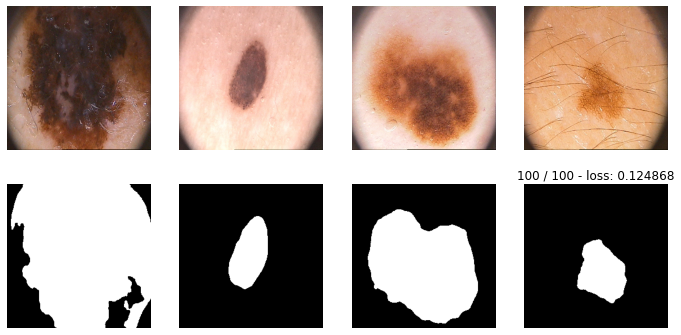

In [ ]:
max_epochs = 100
segnet_history = validate_model(SegNet, 'segnet', 'segnet.pickle', max_epochs=max_epochs)
unet_history = validate_model(UNet, 'unet', 'unet.pickle', max_epochs=max_epochs)
unet2_history = validate_model(UNet2, 'unet2', 'unet2.pickle', max_epochs=max_epochs)

Проверял через кернел на кагле (он мне нравится больше, т.к блокнот очень весомый по ГПУ - 3 часа, а в колабе его можно отправить на компил в бэкграунд). Поэтому последовательность ячеек может не совпадать, дописывал выводы уже в локальном ноутбуке.

# Resume

In [ ]:
# with open('../input/temporary/segnet.pickle', 'rb') as handle:
#     segnet_history = pickle.load(handle)
# with open('../input/temporary/unet.pickle', 'rb') as handle:
#     unet_history = pickle.load(handle)
# with open('../input/temporary/unet2.pickle', 'rb') as handle:
#     unet2_history = pickle.load(handle)

## Что было сделано? Что получилось реализовать?

Изучены на базовом уровне основные модули и классы PyTorch, основные слои моделей, датасеты, лоадеры, трансформы.

Изучены модели для сегментации SegNet и UNet, написана собственная реализация этих моделей. 

*SegNet*

* Total params: 29,443,585
* Params size (MB): 112.32

*Unet (MaxPool2d/Upsample)*

* Total params: 13,387,393
* Params size (MB): 51.07

Кроме того, из UNet получена новая модель путем изменения типа пулинга:

*UNet (Conv2d/ConvTranspose2d)*

* Total params: 34,166,145
* Params size (MB): 130.33

Точность моделей при обучении с применением различных функций потерь приведены ниже (SegNet, UNet, UNet модифицированный):

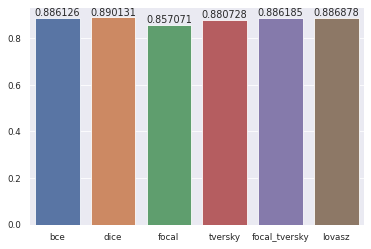

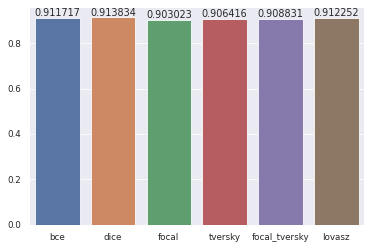

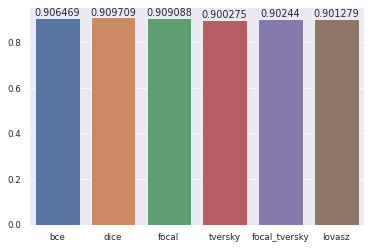

In [ ]:
for history in [segnet_history, unet_history, unet2_history]:
    ax = sns.barplot(x=list(history.keys()), y=[max(m['metric']) for m in history.values()])
    ax.bar_label(ax.containers[0])
    plt.show()

Все модели показывают лучшую точность при использовании Lovasz лосса, следующий по качеству - Dice лосс. Это свидетельствует о том, что функции класса IoU лучше подходят для задач сегментации, чем кросс-энтропийные.

Кроме того (из графиков этого не видно) изначально модели были реализованы без применения BatchNorm слоев, без них модели обучаются хуже.

Выбраны и реализованы функции потерь (бинарная кросс-энтропия в двух вариантах, Dice, Focal, Tversky, Focal Tversky, Lovasz). Для параметризированных функций в ходе написания блокнота подобраны адекватные аргументы.

Ниже показаны графики падения лосса и возрастания метрики при обучения в ходе 100 эпох (SegNet, UNet, UNet модифицированный):

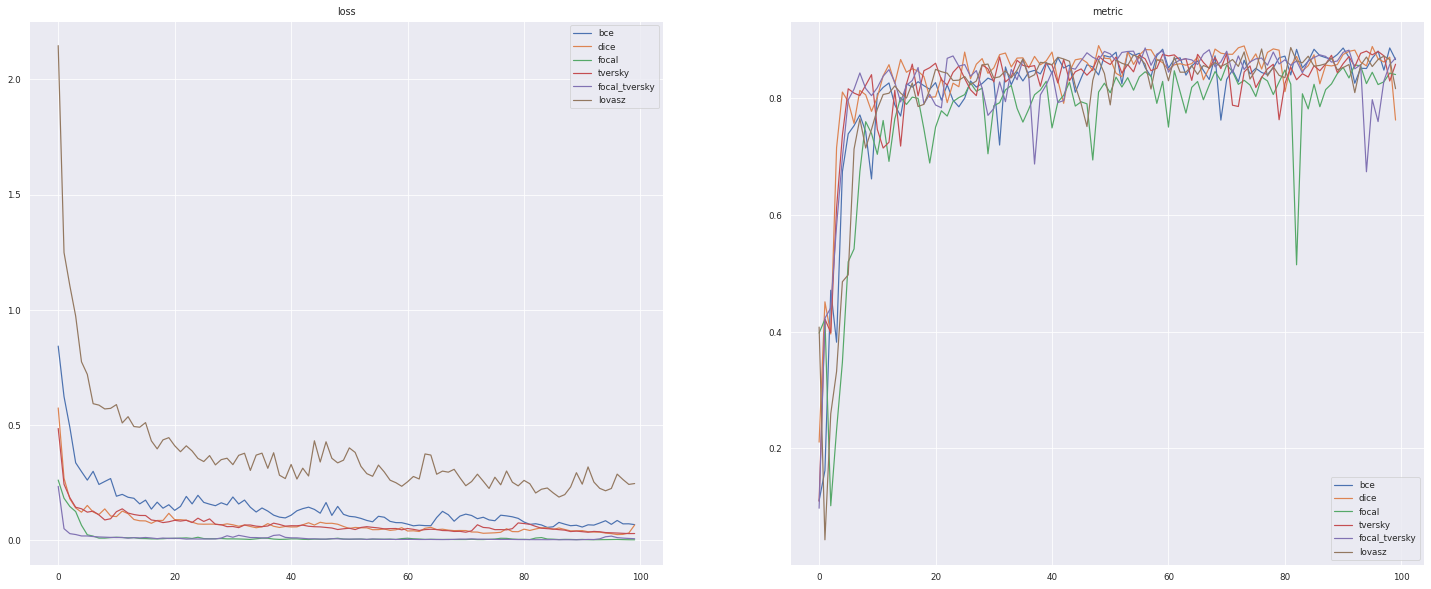

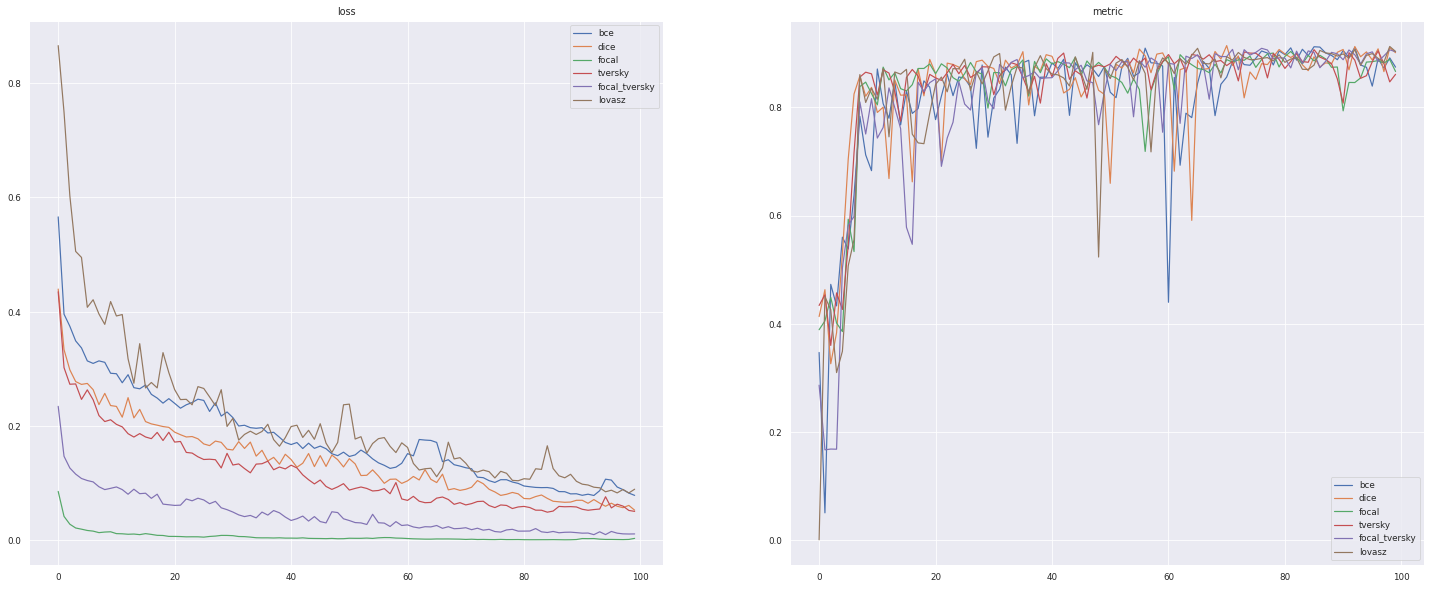

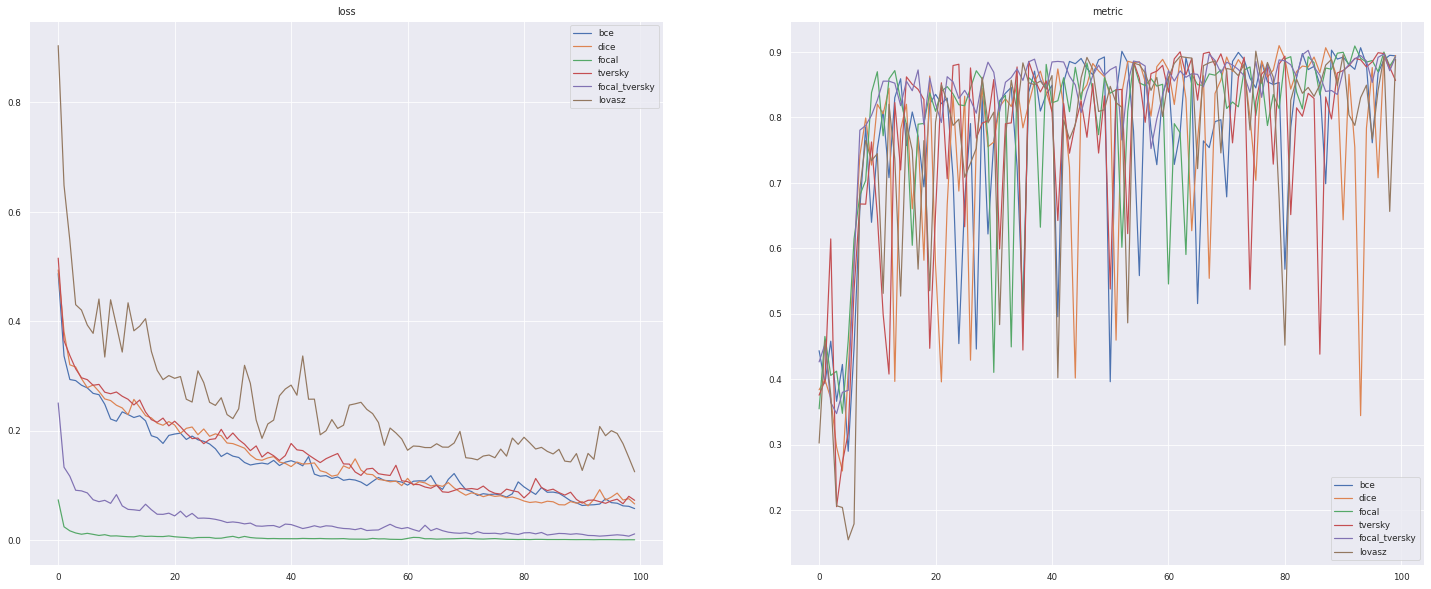

In [ ]:
import seaborn as sns
sns.set(context='paper')

for history in [segnet_history, unet_history, unet2_history]:
    fig, ax = plt.subplots(1, 2, figsize=(25,10))
    x = list(range(max_epochs))
    for key, value in history.items():
        sns.lineplot(x=x, y=value['losses'], ax=ax[0], label=key)
        sns.lineplot(x=x, y=value['metric'], ax=ax[1], label=key)
    ax[0].set_title('loss')
    ax[1].set_title('metric')
    ax[0].legend()
    ax[1].legend()
    fig.show()

При более чем в два раза меньшем количестве параметров UNet показываeт более высокую точность. Замена слоев приводит только к уменьшению точности, и модель хуже обучается (на графиках обучения видны провалы метрики вдвое). Dice, Lovasz и в начале обучения показывают лучшие значения, чем кросс-энтропийные,

Классическая модель UNet обладает большей точностью, но немного медленнее обучается.

## Что не получилось?

Главное - не реализовал валидацию моделей, не смог разобраться, почему метрика так ведет себя в ходе обучения. Точность модели может просесть вполовину, потом выровняться. Особенно это выражено в ходе обучения модифицированной UNet.

Не реализовал сравнение параметров для параметризированных лоссов (коэфициенты подобраны в ходе нескольких экспериментов и зафиксированы.